# Bayesian Network Example using pgmpy

This notebook demonstrates:
1. Defining a Bayesian Network structure
2. Specifying Conditional Probability Tables (CPTs)
3. Performing conditional-independence checks (d-separation)
4. Exact inference by enumeration
5. Factor-graph construction and sum-product message-passing

In [1]:
# Install pgmpy if not already installed
# !pip install pgmpy

In [2]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

from pgmpy.models import DiscreteBayesianNetwork, FactorGraph
from pgmpy.factors.discrete import TabularCPD
from pgmpy.inference import VariableElimination, BeliefPropagation

In [3]:
# 1a. Load data
df = pd.read_csv('diabetes_prediction_dataset.csv')

# 1b. Bin BMI
df['bmi_bin'] = pd.cut(
    df.bmi,
    bins=[0,18.5,25,30,np.inf],
    labels=['Underweight','Normal','Overweight','Obese']
)

# 1c. Bin blood glucose
df['glucose_bin'] = pd.cut(
    df.blood_glucose_level,
    bins=[0,100,140,np.inf],
    labels=['Low','Normal','High']
)

# 1d. Keep and drop NA
data = df[
    ['gender','hypertension','heart_disease','smoking_history',
     'bmi_bin','glucose_bin','diabetes']
].dropna()

# 1e. Convert all to categorical strings
for col in ['gender','hypertension','heart_disease','smoking_history',
            'bmi_bin','glucose_bin','diabetes']:
    data[col] = data[col].astype(str)

data.head()


,gender,hypertension,heart_disease,smoking_history,bmi_bin,glucose_bin,diabetes
0,Female,0,1,never,Overweight,Normal,0
1,Female,0,0,No Info,Overweight,Low,0
2,Male,0,0,never,Overweight,High,0
3,Female,0,0,current,Normal,High,0
4,Male,1,1,current,Normal,High,0


## 1. Defining a Bayesian Network structure

In [4]:
model = DiscreteBayesianNetwork([
    ('gender','diabetes'),
    ('hypertension','diabetes'),
    ('heart_disease','diabetes'),
    ('smoking_history','diabetes'),
    ('bmi_bin','diabetes'),
    ('glucose_bin','diabetes')
])


# 2. Specifying Conditional Probability Tables (CPTs)

In [28]:
import pandas as pd

# 1. Extract the CPT object
cpd = model.get_cpds('diabetes')

# 2. Identify child and parent variables
child = cpd.variable
parents = cpd.variables[1:]    # first element is the child

# 3. Gather state names
state_names = cpd.state_names  # dict mapping each var → list of its states
child_states = state_names[child]
parent_states = [state_names[p] for p in parents]

# 4. Build a MultiIndex of all parent‐configurations
index = pd.MultiIndex.from_product(parent_states, names=parents)

# 5. Get the raw CPT values and transpose so rows match parent‐configs
#    cpd.get_values() returns an array of shape (child_card, prod(evidence_card))
values = cpd.get_values().T

# 6. Build the DataFrame
df_cpt = pd.DataFrame(
    values,
    index=index,
    columns=[f"{child}={s}" for s in child_states]
)

# 7. Display the first few rows
print("First 10 rows of the CPT for 'diabetes':")
print(df_cpt.head(10))

# 8. Optionally save to CSV for full inspection
df_cpt.to_csv('diabetes_CPT.csv')
print("Full CPT saved to diabetes_CPT.csv")



First 10 rows of the CPT for 'diabetes':
                                                                       diabetes=0  \
bmi_bin gender glucose_bin heart_disease hypertension smoking_history               
Normal  Female High        0             0            No Info            0.982882   
                                                      current            0.950680   
                                                      ever               0.946237   
                                                      former             0.936123   
                                                      never              0.965003   
                                                      not current        0.949198   
                                         1            No Info            0.707317   
                                                      current            0.789474   
                                                      ever               0.642857   
                        

## 2.1 Specify Conditional Distributions

## 2.2 Priors for Root Nodes

In [29]:
def make_root_cpd(var):
    # Compute normalized frequency for each state
    freqs = data[var].value_counts(normalize=True).sort_index()
    # Reshape to a (n_states × 1) list of lists
    values = freqs.values.reshape(-1, 1).tolist()
    return TabularCPD(
        variable=var,
        variable_card=len(freqs),
        values=values,
        state_names={var: freqs.index.tolist()}
    )

cpd_gender       = make_root_cpd('gender')
cpd_hypertension = make_root_cpd('hypertension')
cpd_hd           = make_root_cpd('heart_disease')
cpd_smoke        = make_root_cpd('smoking_history')
cpd_bmi          = make_root_cpd('bmi_bin')
cpd_glu          = make_root_cpd('glucose_bin')


## 3.2 Child Node CPT

In [30]:
from pgmpy.estimators import BayesianEstimator

# Fit all CPDs, including the big CPT for 'diabetes', with Dirichlet prior
model.fit(
    data,
    estimator=BayesianEstimator,
    prior_type='dirichlet',
    pseudo_counts=1
)

# Retrieve the CPT for 'diabetes'
cpd_diabetes = model.get_cpds('diabetes')
print(cpd_diabetes)


INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'gender': 'C', 'hypertension': 'C', 'heart_disease': 'C', 'smoking_history': 'C', 'bmi_bin': 'C', 'glucose_bin': 'C', 'diabetes': 'C'}


+-----------------+-----+------------------------------+
| bmi_bin         | ... | bmi_bin(Underweight)         |
+-----------------+-----+------------------------------+
| gender          | ... | gender(Other)                |
+-----------------+-----+------------------------------+
| glucose_bin     | ... | glucose_bin(Normal)          |
+-----------------+-----+------------------------------+
| heart_disease   | ... | heart_disease(1)             |
+-----------------+-----+------------------------------+
| hypertension    | ... | hypertension(1)              |
+-----------------+-----+------------------------------+
| smoking_history | ... | smoking_history(not current) |
+-----------------+-----+------------------------------+
| diabetes(0)     | ... | 0.5                          |
+-----------------+-----+------------------------------+
| diabetes(1)     | ... | 0.5                          |
+-----------------+-----+------------------------------+


# 3. Performing conditional-independence checks (d-separation)

In [31]:
# Conditional-Independence Checks via d-Separation

import networkx as nx
from networkx.algorithms.d_separation import d_separated

# 1. Build a plain DiGraph from the BayesianNetwork edges
G = nx.DiGraph()
G.add_nodes_from(model.nodes())
G.add_edges_from(model.edges())

# 2. Define a helper to print results
def check_sep(X, Y, Z):
    sep = d_separated(G, {X}, {Y}, set(Z))
    print(f"{X} ⟂ {Y} | {Z}?  --> {sep}")

# 3. Perform checks
check_sep('gender',        'heart_disease',    [])                # root vs root
check_sep('gender',        'hypertension',     ['diabetes'])     # conditional on child
check_sep('bmi_bin',       'smoking_history',  ['diabetes'])     # conditional on common child


gender ⟂ heart_disease | []?  --> True
gender ⟂ hypertension | ['diabetes']?  --> False
bmi_bin ⟂ smoking_history | ['diabetes']?  --> False


C:\Users\crist\AppData\Local\Temp\ipykernel_33372\338394384.py:13: DeprecationWarning: d_separated is deprecated and will be removed in NetworkX v3.5.Please use `is_d_separator(G, x, y, z)`.
  sep = d_separated(G, {X}, {Y}, set(Z))


# Exact inference by enumeration

In [33]:
# 7. Exact Inference by Enumeration
from pgmpy.inference import VariableElimination

# Create inference object
infer = VariableElimination(model)

# Query: P(diabetes | bmi_bin=Obese, glucose_bin=High)
posterior = infer.query(
    variables=['diabetes'],
    evidence={'bmi_bin': 'Obese', 'glucose_bin': 'High'}
)

# Print the resulting posterior distribution
print("Exact inference result:")
print(posterior)


Exact inference result:
+-------------+-----------------+
| diabetes    |   phi(diabetes) |
+=============+=================+
| diabetes(0) |          0.7661 |
+-------------+-----------------+
| diabetes(1) |          0.2339 |
+-------------+-----------------+


# Factor‐Graph & Sum‐Product Message‐Passing

In [34]:
from pgmpy.models import FactorGraph
from pgmpy.inference import BeliefPropagation

# 1. Build an empty FactorGraph
fg = FactorGraph()

# 2. Add all variable nodes
fg.add_nodes_from(model.nodes())

# 3. Add factors (one per CPD) and connect them
for cpd in model.get_cpds():
    factor = cpd.to_factor()
    fg.add_factors(factor)
    # Connect each variable in the factor’s scope to the factor node
    for var in factor.scope():
        fg.add_edge(var, factor)

# 4. Run Belief Propagation
bp = BeliefPropagation(fg)

# 5. Query the same evidence you used for enumeration:
#    Only use variables actually in the model!
fg_post = bp.query(
    variables=['diabetes'],
    evidence={'bmi_bin': 'Obese', 'glucose_bin': 'High'}
)

# 6. Display the posterior
print(fg_post)


+-------------+-----------------+
| diabetes    |   phi(diabetes) |
+=============+=================+
| diabetes(0) |          0.7661 |
+-------------+-----------------+
| diabetes(1) |          0.2339 |
+-------------+-----------------+


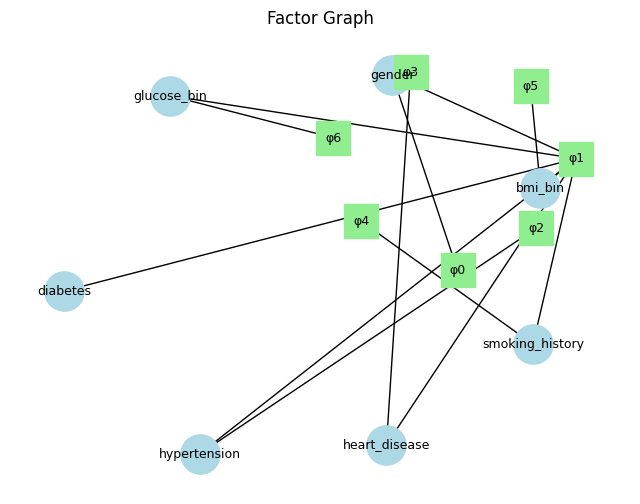

In [35]:
import networkx as nx

# Plot the factor graph
plt.figure(figsize=(8, 6))
variable_nodes = list(model.nodes())
factor_nodes = [n for n in fg.nodes() if n not in variable_nodes]

pos_var = nx.spring_layout(fg.subgraph(variable_nodes), seed=1)
pos_fac = nx.spring_layout(fg.subgraph(factor_nodes), seed=2)
pos = {**pos_var, **{k: v*0.5+0.5 for k, v in pos_fac.items()}}

nx.draw_networkx_nodes(fg, pos, nodelist=variable_nodes,
                       node_color='lightblue', node_shape='o', node_size=800)
nx.draw_networkx_nodes(fg, pos, nodelist=factor_nodes,
                       node_color='lightgreen', node_shape='s', node_size=600)
nx.draw_networkx_edges(fg, pos, width=1)
nx.draw_networkx_labels(fg, pos,
                        labels={n: n for n in variable_nodes},
                        font_size=9)
nx.draw_networkx_labels(fg, pos,
                        labels={n: f"φ{idx}" for idx, n in enumerate(factor_nodes)},
                        font_size=9)

plt.title("Factor Graph")
plt.axis('off')
plt.show()
